In [3]:
import glob

import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import metpy
import cartopy.feature as cfeature
import os

from tqdm.notebook import tqdm

xr.set_options(keep_attrs=True);

In [4]:
df = pd.concat(
    [pd.read_csv(f'/Volumes/Shores/EPA/daily_88101_{year}.csv') for year in range(2017, 2022)],
    axis=0
)

In [7]:
df[['Latitude', 'Longitude']].drop_duplicates()

,Latitude,Longitude
0,30.497478,-87.880258
110,33.284928,-85.803608
228,34.762619,-87.638097
347,34.288567,-85.969858
462,33.991494,-85.992647
...,...,...
571341,44.020855,-90.401640
577066,41.324170,-105.614890
577461,41.308825,-105.549130
577758,44.288005,-105.517022


EPA data downloaded from here: [https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw)

ERA5 data downloaded from here: 

1. [ERA5-Land (meteorology)](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview)
1. [ERA5 Single Levels (pblh)](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)

This file creates two dataset. The first is the training dataset and matches the satellite and meteorology data to the PM2.5 (which are single points). The second creates a gridded dataset that matches AOD with meteorology so that predictive maps can be made.

In [23]:
with xr.open_dataset('/Volumes/Shores/GOES/AODC/averages/2021/daily/001.nc') as aod_for_crs:
    aod_for_crs.load()

In [24]:
geo = aod_for_crs.metpy.parse_cf('AOD').metpy.cartopy_crs
plate = ccrs.PlateCarree()
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)

# Matching AOD to PM

In [2]:
def read_and_trim_PM(file, aod, geo, plate):
    df = pd.read_csv(file, parse_dates=['Date Local'])

    df.rename(columns = {
        'Date Local':'time', 
        'Arithmetic Mean': 'value',
        'Latitude': 'latitude',
        'Longitude': 'longitude'
    }, inplace = True)

    keep = ['latitude', 'longitude', 'time', 'value','Local Site Name', 'Address', 'State Name', 'County Name','City Name', 'POC']
    df.drop(columns=df.columns.difference(keep),inplace=True)

    df = df.loc[df.value >= 0]

    transformed = geo.transform_points(src_crs=plate, x=df['longitude'], y=df['latitude'])
    df['proj_longitude'] = transformed[:,0]
    df['proj_latitude'] = transformed[:,1]

    sat_h = aod.goes_imager_projection.perspective_point_height
    minx, maxx = aod.x.min().item() * sat_h, aod.x.max().item() * sat_h
    miny, maxy = aod.y.min().item() * sat_h, aod.y.max().item() * sat_h

    # drop locations that are not observable by GOES-16
    df = df[
        (df.proj_longitude >= minx) & 
        (df.proj_longitude <= maxx) & 
        (df.proj_latitude >= miny) & 
        (df.proj_latitude <= maxy)
    ]
    
    return df

In [ ]:
matched_pm = {str(x):0 for x in range(2017, 2022)}
not_matched_pm = {str(x):0 for x in range(2017, 2022)}

errors = {str(x):[] for x in range(2017, 2022)}

year_pbar = tqdm(map(str, range(2017, 2022)), total=4)
for year in year_pbar:
    year_pbar.set_description(year)
    
    files = sorted(glob.glob(f'/Volumes/Shores/GOES/AODC/averages/{year}/daily/*.nc'))
    
    df = read_and_trim_PM(f'/Volumes/Shores/EPA/daily_88101_{year}.csv', 
                      aod_for_crs, geo, plate)
    
    df['AOD'] = np.full_like(df.value, fill_value=np.nan)
    df.set_index(['time', 'longitude', 'latitude'], inplace=True)
    df.sort_index(inplace=True)
    
    pbar = tqdm(files)
    for day_file in pbar:
        if (idx == 260) and (year == '2020'):
            # for whatever reason this day (2020-9-16) caused the kernel to crash
            continue
        try:
            with xr.open_dataset(day_file) as ds:
                ds.load()
            sat_h = ds.goes_imager_projection.perspective_point_height
            ds = ds.assign_coords(x=ds.x*sat_h, y = ds.y*sat_h)

            tm = pd.to_datetime(ds.t.item()).strftime('%Y-%m-%d')
            pbar.set_description(tm)
            if np.isfinite(ds.AOD).any():
                sub = df.loc[tm]
                for (lon, lat), row in sub.iterrows():
                    try:
                        data = ds.sel(
                            x=row.proj_longitude, 
                            y=row.proj_latitude, 
                            method='nearest', 
                            tolerance=2000
                        )
                        if np.isfinite(data.AOD):
                            df.loc[(tm, lon, lat), 'AOD'] = data.AOD.item()
                            matched_pm[year] += 1
                    except Exception as e:
                        not_matched_pm[year] += 1
        except:
            errors[year].append(day_file)
            
    print(matched_pm)
#     df.reset_index().dropna().to_csv(f'data/{year}-matched-no_nan.csv', index=False)

#### Some Plots

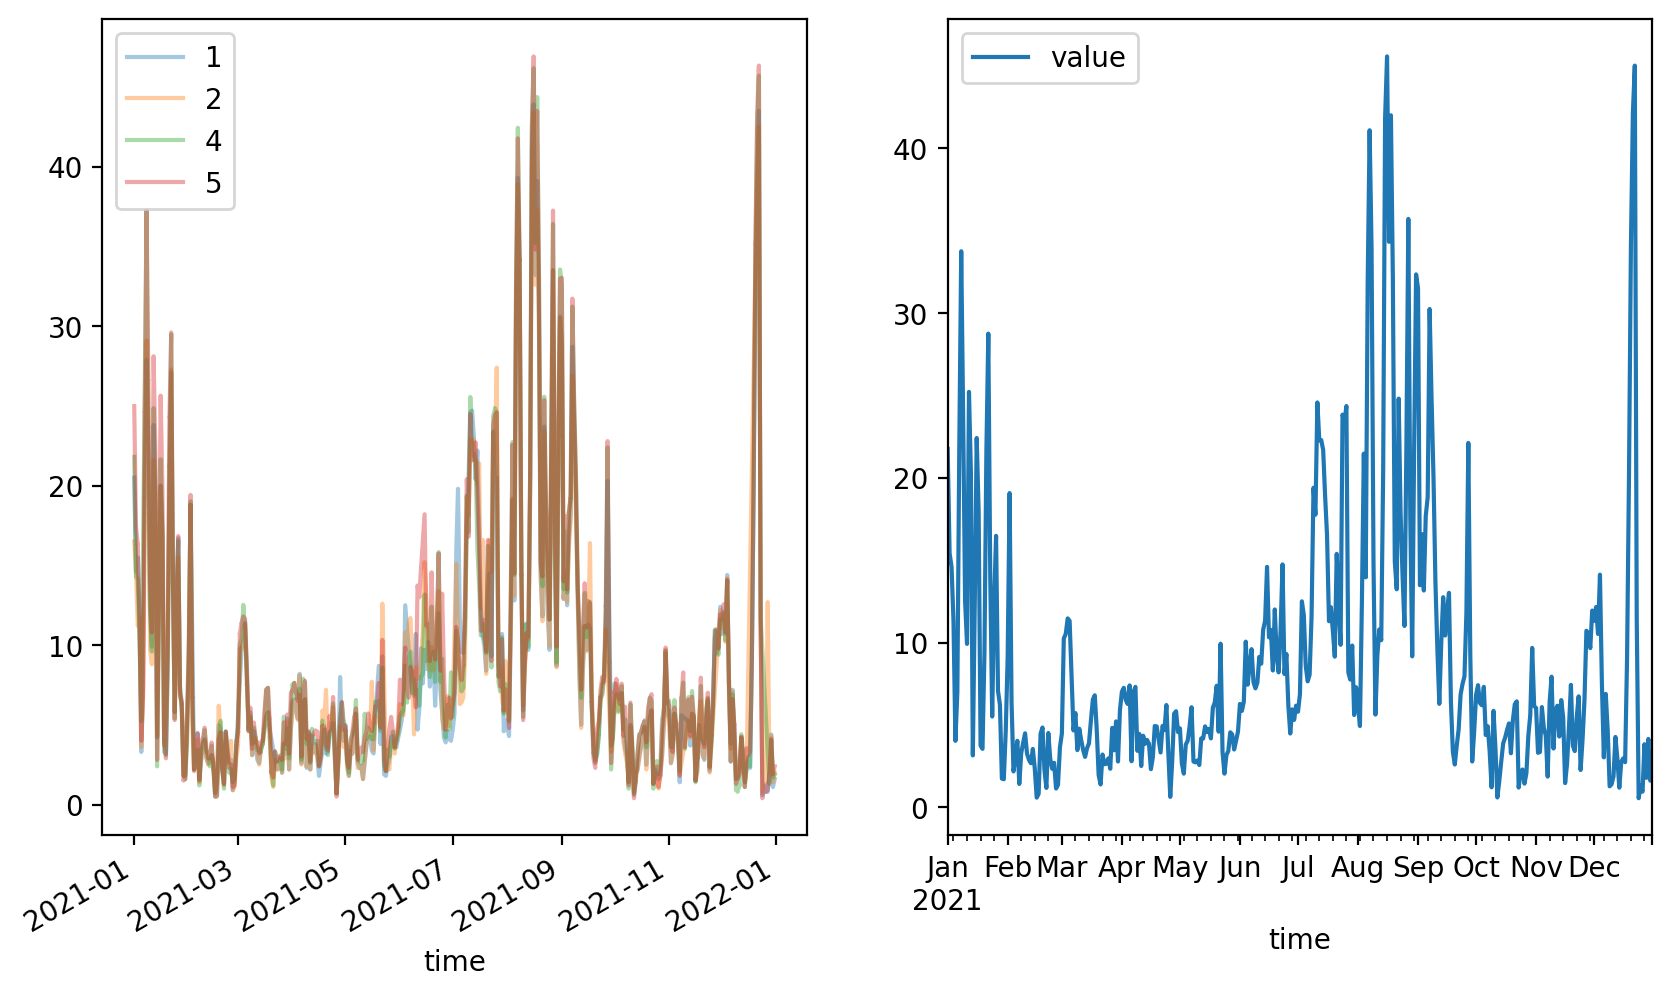

In [118]:
x = 0
for g, adf in df.groupby(['longitude', 'latitude']):
#     print(adf.POC.unique(), adf.POC.unique().shape)
    try:
        if adf.POC.unique().shape[0] > 3:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6), dpi=200)
            adf.set_index('time').sort_index().groupby('POC').value.plot(legend=True, ax=ax1, alpha=0.4)
            adf.groupby('time').mean().sort_index().value.plot(legend=True, ax=ax2)
#             x += 1
#             if x > 10:
            raise StopIteration
    except:
        break

In [126]:
# for locations that have more than one observation at the same time, average them
df = df.groupby(['longitude', 'latitude', 'time']).mean()
df.reset_index(inplace=True)

In [127]:
df

,longitude,latitude,time,POC,value,proj_longitude,proj_latitude
0,-124.179490,40.776780,2021-01-01,1.0,6.8,-3.330026e+06,3.787764e+06
1,-124.179490,40.776780,2021-01-04,1.0,6.4,-3.330026e+06,3.787764e+06
2,-124.179490,40.776780,2021-01-07,1.0,4.7,-3.330026e+06,3.787764e+06
3,-124.179490,40.776780,2021-01-10,1.0,15.2,-3.330026e+06,3.787764e+06
4,-124.179490,40.776780,2021-01-13,1.0,12.6,-3.330026e+06,3.787764e+06
...,...,...,...,...,...,...,...
274987,-64.784868,17.712474,2021-11-30,3.0,2.8,1.064197e+06,1.905148e+06
274988,-64.784868,17.712474,2021-12-06,3.0,3.8,1.064197e+06,1.905148e+06
274989,-64.784868,17.712474,2021-12-18,3.0,3.9,1.064197e+06,1.905148e+06
274990,-64.784868,17.712474,2021-12-24,3.0,3.5,1.064197e+06,1.905148e+06


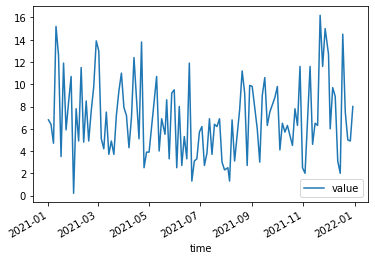

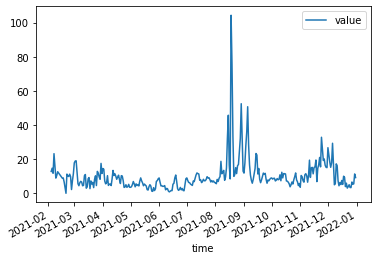

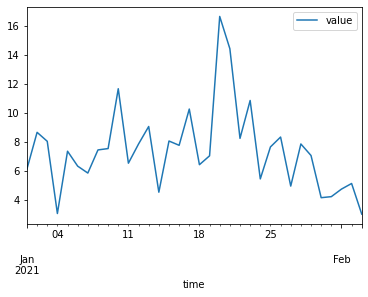

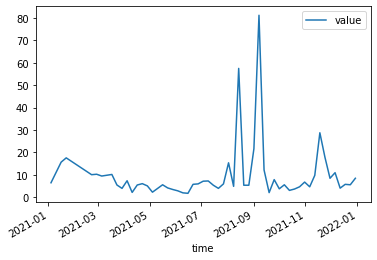

In [130]:
x = 0
for g, adf in df.groupby(['longitude', 'latitude']):
    try:
        fig, ax = plt.subplots()
        adf.set_index('time').sort_index().value.plot(legend=True, ax=ax)
        x += 1
        if x > 3:
            raise StopIteration
    except:
        break

# Matching Meteorology to the result of the previous section

In [3]:
files = sorted(glob.glob(f'data/*-aod-pm-match.csv'))

In [49]:
df = pd.concat([pd.read_csv(i, parse_dates=['time']) for i in files], axis=0)

In [50]:
df

,time,longitude,latitude,POC,value,Local Site Name,Address,State Name,County Name,City Name,proj_longitude,proj_latitude,AOD
0,2017-05-24,-109.870760,42.869824,1,4.181818,Pinedale Gaseous,Pinedale Gaseous Monitor on west side of City ...,Wyoming,Sublette,Not in a city,-2.479831e+06,4.014213e+06,0.083098
1,2017-05-24,-109.870760,42.869824,1,4.100000,Pinedale Gaseous,Pinedale Gaseous Monitor on west side of City ...,Wyoming,Sublette,Not in a city,-2.479831e+06,4.014213e+06,0.083098
2,2017-05-24,-109.561472,40.464710,4,5.583333,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,-2.565700e+06,3.846115e+06,1.031703
3,2017-05-24,-109.561472,40.464710,4,5.500000,Vernal #4,628 North 1700 West,Utah,Uintah,Vernal,-2.565700e+06,3.846115e+06,1.031703
4,2017-05-24,-109.455315,47.048537,3,2.756522,Lewistown,303 East Aztec Drive Lewistown MT 59457,Montana,Fergus,Not in a city,-2.265720e+06,4.289011e+06,0.757455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259678,2021-12-31,-76.953426,38.894770,1,7.800000,Near Road,3600 Benning Road N.E.,District Of Columbia,District of Columbia,Washington,-1.620836e+05,3.817653e+06,0.418024
259679,2021-12-31,-76.059210,43.052350,4,12.233333,EAST SYRACUSE,"5895 ENTERPRISE PARKWAY,",New York,Onondaga,East Syracuse,-8.180915e+04,4.115855e+06,0.211089
259680,2021-12-31,-76.059210,43.052350,4,12.200000,EAST SYRACUSE,"5895 ENTERPRISE PARKWAY,",New York,Onondaga,East Syracuse,-8.180915e+04,4.115855e+06,0.211089
259681,2021-12-31,-73.821530,40.736140,4,18.379167,QUEENS COLLEGE 2,Queens College 65-30 Kissena Blvd Parking L...,New York,Queens,New York,9.485095e+04,3.953348e+06,0.462988


In [10]:
with xr.open_dataset(f'/Volumes/Shores/ERA5/new2/era5_land_201705.nc') as met:
        met.load()

met = met.resample(time='1d').mean()

In [11]:
with xr.open_dataset('/Volumes/Shores/ERA5/era5_pblh_2017.nc') as pblh:
    pblh.load()
    
pblh = pblh.resample(time='1d').mean()

In [22]:
for c in met.data_vars:
    df[c] = np.full_like(df.value, fill_value=np.nan)
for c in pblh.data_vars:
    df[c] = np.full_like(df.value, fill_value=np.nan)

In [51]:
df.set_index(['time', 'longitude', 'latitude'], inplace=True)
df.sort_index(inplace=True)

In [61]:
pbar = tqdm(df.groupby(['time', 'longitude', 'latitude']))

for (time, lon, lat), _ in pbar:
    pbar.set_description(time.strftime('%Y-%m-%d'))
    
    if time not in met.time:
        print(f'loading new met dataset: era5_land_{time.year}{time.month:02}.nc', end= ' ... ')
        del met
        with xr.open_dataset(f'/Volumes/Shores/ERA5/new2/era5_land_{time.year}{time.month:02}.nc') as met:
            met.load()
        met = met.resample(time='1d').mean()
        print('done')
        
    if time not in pblh.time:
        print(f'loading new blh dataset: era5_pblh_{time.year}.nc', end= ' ... ')
        del pblh
        with xr.open_dataset(f'/Volumes/Shores/ERA5/era5_pblh_{time.year}.nc') as pblh:
            pblh.load()
        pblh = pblh.resample(time='1d').mean()
        print('done')

    data = met.sel(longitude=lon, latitude=lat, time=time, method='nearest')
    df.loc[(time, lon, lat), "u10"] = data["u10"].item()
    df.loc[(time, lon, lat), "v10"] = data["v10"].item()
    df.loc[(time, lon, lat), "d2m"] = data["d2m"].item()
    df.loc[(time, lon, lat), "t2m"] = data["t2m"].item()
    df.loc[(time, lon, lat), "lai_hv"] = data["lai_hv"].item()
    df.loc[(time, lon, lat), "lai_lv"] = data["lai_lv"].item()
    df.loc[(time, lon, lat), "sp"] = data["sp"].item()
    df.loc[(time, lon, lat), "skt"] = data["skt"].item()
    df.loc[(time, lon, lat), "tp"] = data["tp"].item()
    
    data = pblh.sel(longitude=lon, latitude=lat, time=time, method='nearest')
    df.loc[(time, lon, lat), "blh"] = data["blh"].item()

  0%|          | 0/499511 [00:00<?, ?it/s]

loading new met dataset: era5_land_201705.nc ... done
loading new met dataset: era5_land_201706.nc ... done
loading new met dataset: era5_land_201707.nc ... done
loading new met dataset: era5_land_201708.nc ... done
loading new met dataset: era5_land_201709.nc ... done
loading new met dataset: era5_land_201710.nc ... done
loading new met dataset: era5_land_201711.nc ... done
loading new met dataset: era5_land_201712.nc ... done
loading new met dataset: era5_land_201801.nc ... done
loading new blh dataset: era5_pblh_2018.nc ... done
loading new met dataset: era5_land_201802.nc ... done
loading new met dataset: era5_land_201803.nc ... done
loading new met dataset: era5_land_201804.nc ... done
loading new met dataset: era5_land_201805.nc ... done
loading new met dataset: era5_land_201806.nc ... done
loading new met dataset: era5_land_201807.nc ... done
loading new met dataset: era5_land_201808.nc ... done
loading new met dataset: era5_land_201809.nc ... done
loading new met dataset: era5_

In [88]:
df.reset_index().dropna().to_csv('data/matched/all_years_matched.csv', index=False)

In [66]:
df.reset_index(inplace=True)

In [68]:
sub = df[df.isna().any(axis=1)]

In [79]:
sub.reset_index().to_csv('data/matched/locations_with_nans.csv', index=False)

In [72]:
sub

POC      value          Local Site Name  \
time       longitude  latitude                                             
2017-05-24 -76.141006 38.587525    3   2.375000               Horn Point   
                      38.587525    3   2.300000               Horn Point   
2017-05-25 -89.395916 30.300833    1   5.600000                 Waveland   
           -87.203550 30.525367    1   4.300000  Ellyson Industrial Park   
           -76.141006 38.587525    3   1.916667               Horn Point   
...                              ...        ...                      ...   
2021-12-31 -97.431553 27.804489    4  19.200000  Corpus Christi Huisache   
           -89.395916 30.300833    3   7.416667                 Waveland   
                      30.300833    3   7.400000                 Waveland   
           -80.628611 28.053611    3   9.912500                Melbourne   
                      28.053611    3   9.900000                Melbourne   

                                                                           Address  \
time       longitude  latitude                                                       
2017-05-24 -76.141006 38.587525  University of Maryland for Environmental and E...   
                      38.587525  University of Maryland for Environmental and E...   
2017-05-25 -89.395916 30.300833                                      400 Baltic St   
           -87.203550 30.525367                ELLYSON INDUSTRIAL PARK-COPTER ROAD   
           -76.141006 38.587525  University of Maryland for Environmental and E...   
...                                                                            ...   
2021-12-31 -97.431553 27.804489                               3810 Huisache Street   
           -89.395916 30.300833                                      400 Baltic St   
                      30.300833                                      400 Baltic St   
           -80.628611 28.053611       401 West Florida Avenue, Melbourne, FL 32901   
                      28.053611       401 West Florida Avenue, Melbourne, FL 32901   

                                  State Name County Name       City Name  \
time       longitude  latitude                                             
2017-05-24 -76.141006 38.587525     Maryland  Dorchester   Not in a city   
                      38.587525     Maryland  Dorchester   Not in a city   
2017-05-25 -89.395916 30.300833  Mississippi     Hancock        Waveland   
           -87.203550 30.525367      Florida    Escambia      Ferry Pass   
           -76.141006 38.587525     Maryland  Dorchester   Not in a city   
...                                      ...         ...             ...   
2021-12-31 -97.431553 27.804489        Texas      Nueces  Corpus Christi   
           -89.395916 30.300833  Mississippi     Hancock        Waveland   
                      30.300833  Mississippi     Hancock        Waveland   
           -80.628611 28.053611      Florida     Brevard       Melbourne   
                      28.053611      Florida     Brevard       Melbourne   

                                 proj_longitude  proj_latitude       AOD  u10  \
time       longitude  latitude                                                  
2017-05-24 -76.141006 38.587525   -9.515892e+04   3.794700e+06  0.354455  NaN   
                      38.587525   -9.515892e+04   3.794700e+06  0.354455  NaN   
2017-05-25 -89.395916 30.300833   -1.325985e+06   3.101103e+06  0.181258  NaN   
           -87.203550 30.525367   -1.126002e+06   3.124862e+06  0.226279  NaN   
           -76.141006 38.587525   -9.515892e+04   3.794700e+06  0.305044  NaN   
...                                         ...            ...       ...  ...   
2021-12-31 -97.431553 27.804489   -2.077743e+06   2.858452e+06  0.647686  NaN   
           -89.395916 30.300833   -1.325985e+06   3.101103e+06  0.324557  NaN   
                      30.300833   -1.325985e+06   3.101103e+06  0.324557  NaN   
           -80.628611 28.053611   -5.389740e+

# Gridded Dataset

In [4]:
with xr.open_dataset('/Volumes/Shores/ERA5/era5_pblh_2021.nc') as pblh:
    pblh.load()
    
pblh = pblh.resample(time='1d').mean()

In [6]:
with xr.open_dataset(files[0]) as aod:
    aod.load()

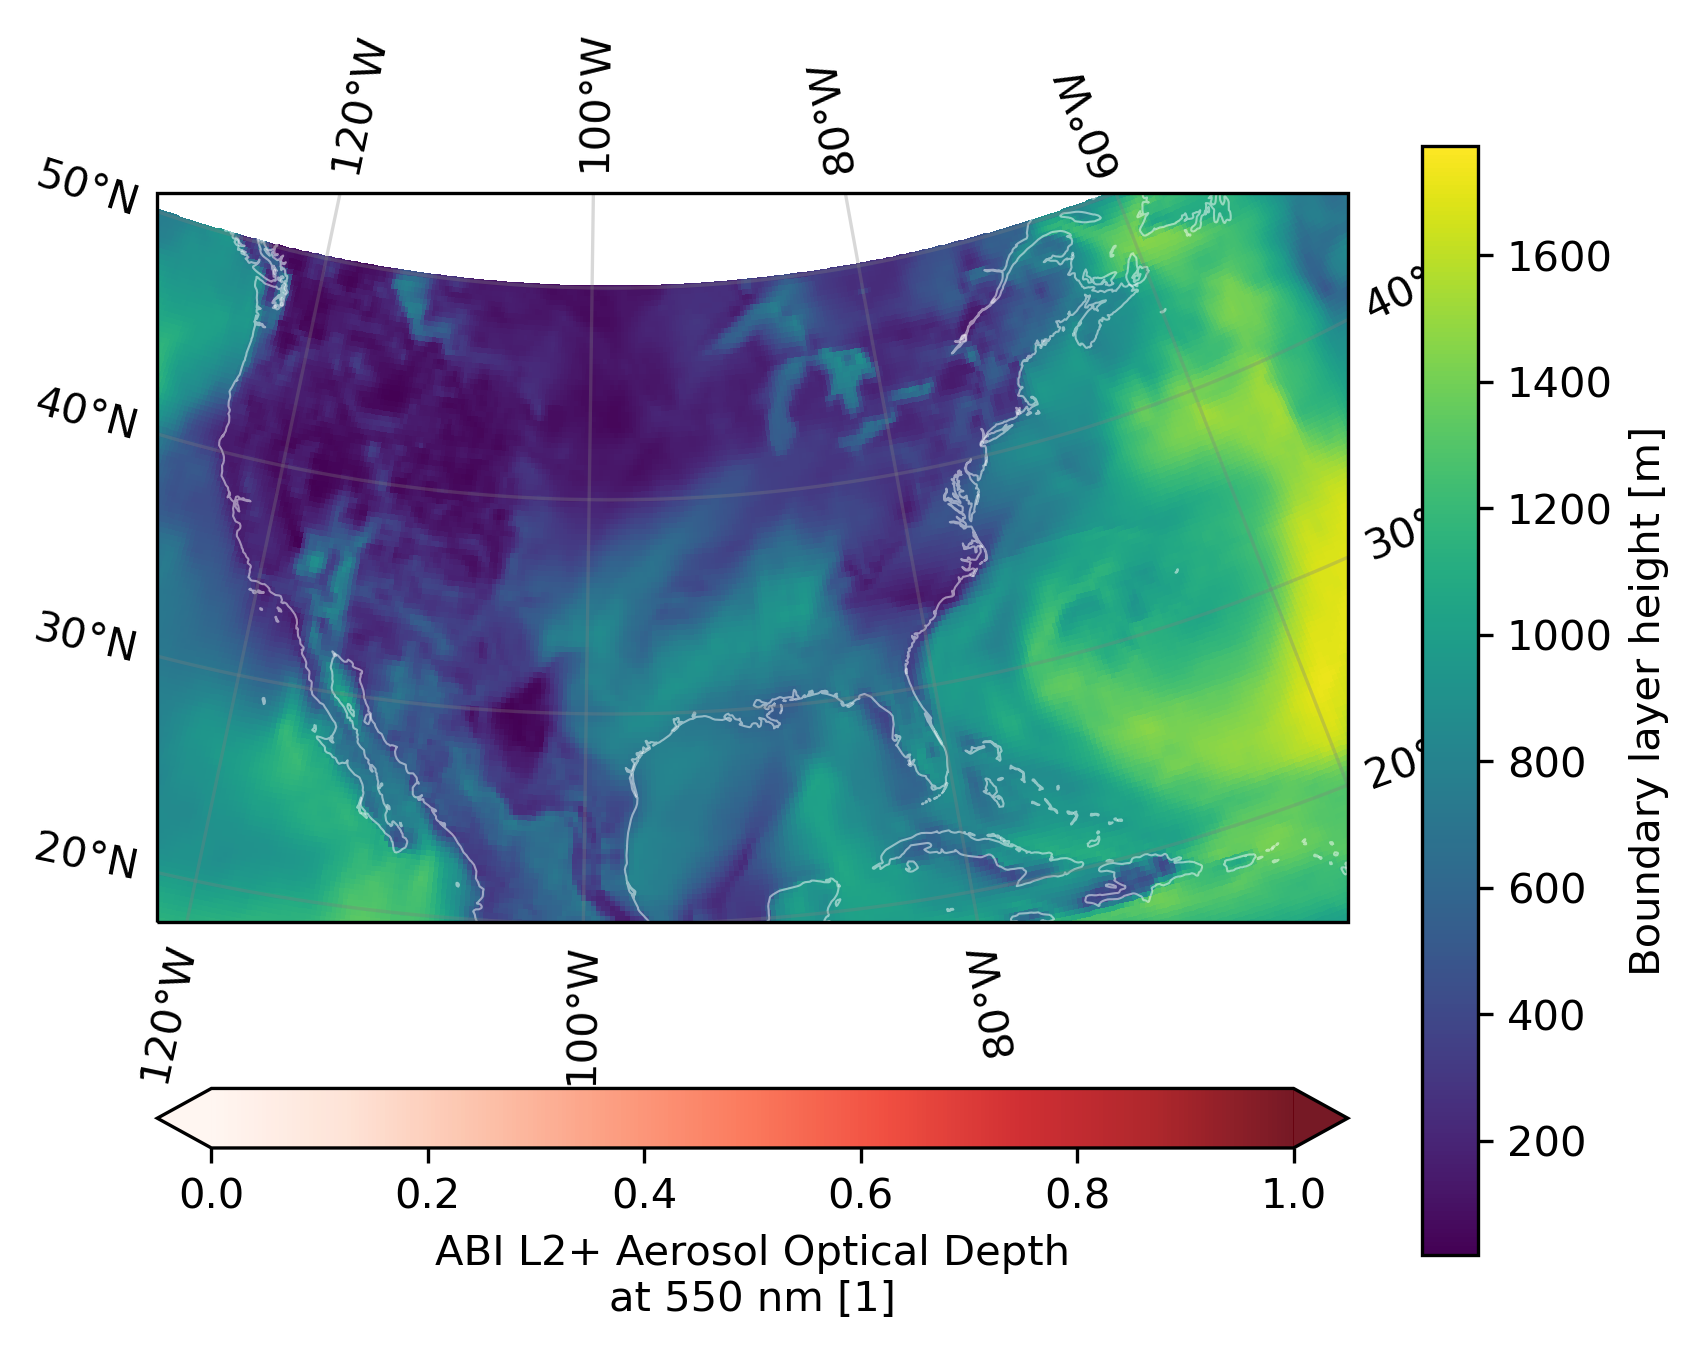

In [7]:
fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection=equal_area))

pblh['blh'].isel(time=0).plot(ax=ax, transform=plate)

aod.AOD.plot(ax=ax, transform=geo, alpha=0.9, vmin=0, vmax=1, cmap='Reds',
             cbar_kwargs={'orientation': 'horizontal'}
            )

ax.set_title('')

ax.set_extent([-122, -60, 20, 50], crs=plate)

ax.gridlines(draw_labels=True, color='grey', alpha=0.3)
ax.coastlines(lw=0.5, color='white', alpha=0.5);

In [6]:
files = sorted(glob.glob(f'/Volumes/Shores/GOES/AODC/averages/2021/daily/*.nc'))
pbar = tqdm(files[152:])
next_met = pd.to_datetime('2021-07-01').day_of_year
drop = ['x_image', 'y_image', 'sunglint_angle', 'retrieval_local_zenith_angle', 'quantitative_local_zenith_angle','retrieval_solar_zenith_angle','quantitative_solar_zenith_angle','aod_product_wavelength']

cache = {}
cache['blh'] = {}
cache['met'] = {}

met = None

for idx, file in enumerate(pbar):
    with xr.open_dataset(file) as aod:
        aod.load()
        
    tm = pd.to_datetime(aod.t.item())
    tm_str = tm.strftime('%Y-%m-%d')
    pbar.set_description(tm_str)
    
    output = f'/Volumes/Shores/matched/{tm.day_of_year:03}.nc'
    
    if os.path.exists(output):
        continue
    
    if (met is None) or (tm not in met.time):
        with xr.open_dataset(f'/Volumes/Shores/ERA5/new/era5_land_2021{tm.month:02}.nc') as met:
            met.load()
        met_dat = met.sel(time=tm_str).resample(time='1d').mean()
        print('done')
    
    sat_h = aod.goes_imager_projection.perspective_point_height
    aod = aod.assign_coords(x=aod.x*sat_h, y = aod.y*sat_h)
    
    for c in met.data_vars:
        aod[c] = xr.full_like(aod.AOD, fill_value=np.nan)
        aod[c].attrs = {}
    aod['blh'] = xr.full_like(aod.AOD, fill_value=np.nan)
    aod['blh'].attrs = {}
    
    aod_df = aod.AOD.drop_vars(drop).to_dataframe().dropna().reset_index()
    
    transformed = plate.transform_points(src_crs=geo, x=aod_df['x'], y=aod_df['y'])
    aod_df['proj_longitude'] = transformed[:,0]
    aod_df['proj_latitude'] = transformed[:,1]
    
    for _, row in tqdm(aod_df.iterrows(), total=aod_df.shape[0]):
        if (row.proj_longitude, row.proj_latitude) not in cache['blh']:
            blh_sel = pblh.sel(time=tm_str, longitude=row.proj_longitude, latitude=row.proj_latitude, method='nearest')
            cache['blh'][(row.x, row.y)] = (blh_sel.longitude.item(), blh_sel.latitude.item())
        else:
            lon, lat = cache['blh'](row.x.item(), row.y.item())
            blh_sel = pblh.sel(time=tm_str, longitude=lon, latitude=lat)

        if (row.proj_longitude, row.proj_latitude) not in cache['met']:
            met_sel = met_dat.sel(time=tm_str, longitude=row.proj_longitude, latitude=row.proj_latitude, method='nearest')
            cache['met'][(row.x, row.y)] = (met_sel.longitude.item(), met_sel.latitude.item())
        else:
            lon, lat = cache['met'](row.x, row.y)
            met_sel = met_dat.sel(time=tm_str, longitude=lon, latitude=lat)

        aod['blh'].loc[dict(t=tm_str, x=row.x, y=row.y)] = blh_sel.blh.item()
        aod['u10'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.u10.item()
        aod['v10'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.v10.item()
        aod['d2m'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.d2m.item()
        aod['t2m'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.t2m.item()
        aod['lai_hv'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.lai_hv.item()
        aod['lai_lv'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.lai_lv.item()
        aod['skt'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.skt.item()
        aod['sp'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.sp.item()
    
    aod.to_netcdf(output)

  0%|          | 0/213 [00:00<?, ?it/s]

  0%|          | 0/511645 [00:00<?, ?it/s]

  0%|          | 0/556446 [00:00<?, ?it/s]

  0%|          | 0/647549 [00:00<?, ?it/s]

  0%|          | 0/665118 [00:00<?, ?it/s]

  0%|          | 0/621865 [00:00<?, ?it/s]

  0%|          | 0/561005 [00:00<?, ?it/s]

  0%|          | 0/561996 [00:00<?, ?it/s]

  0%|          | 0/629742 [00:00<?, ?it/s]

  0%|          | 0/666380 [00:00<?, ?it/s]

  0%|          | 0/695232 [00:00<?, ?it/s]

  0%|          | 0/769605 [00:00<?, ?it/s]

  0%|          | 0/796608 [00:00<?, ?it/s]

  0%|          | 0/719034 [00:00<?, ?it/s]

  0%|          | 0/605981 [00:00<?, ?it/s]

  0%|          | 0/558862 [00:00<?, ?it/s]

  0%|          | 0/668864 [00:00<?, ?it/s]

  0%|          | 0/575807 [00:00<?, ?it/s]

  0%|          | 0/420713 [00:00<?, ?it/s]

  0%|          | 0/542644 [00:00<?, ?it/s]

  0%|          | 0/527127 [00:00<?, ?it/s]

  0%|          | 0/613888 [00:00<?, ?it/s]

Oops. When I downloaded the met data to make these, I had accidentally selected the skin temperature (skt) instead of the total precipitation (tp). So, the dataset I'm making here doesn't have the same features as the one I used to train the model. I downloaded datasets only containing tp and will now reopen all the dataset made above and assign tp to the correct location and also drop skt.

In [6]:
files = sorted(glob.glob(f'/Volumes/Shores/matched/*.nc'))
pbar = tqdm(files[100:])
drop = ['x_image', 'y_image', 'sunglint_angle', 'retrieval_local_zenith_angle', 'quantitative_local_zenith_angle','retrieval_solar_zenith_angle','quantitative_solar_zenith_angle','aod_product_wavelength']

met = None

for idx, file in enumerate(pbar):
    with xr.open_dataset(file) as ds:
        ds.load()
    
    if 'tp' in ds.data_vars:
        continue
        
    tm = pd.to_datetime(ds.t.item())
    tm_str = tm.strftime('%Y-%m-%d')
    pbar.set_description(tm_str)
    
    if (met is None) or (tm not in met.time):
        print(f'loading new met dataset: era5_land_{tm.year}{tm.month:02}.nc', end= ' ... ')
        with xr.open_dataset(f'/Volumes/Shores/ERA5/era5_land/era5_land_{tm.year}{tm.month:02}.nc') as met:
            met.load()
        print('done')
        
    met_dat = met.sel(time=tm_str).resample(time='1d').mean()
    
    for c in met.data_vars:
        if c == 'tp':
            continue
        ds[c].attrs = met[c].attrs
    ds['blh'].attrs = pblh.attrs
    ds['tp'] = xr.full_like(ds.AOD, fill_value=np.nan)
    ds['tp'].attrs = met['tp'].attrs
    
    aod_df = ds.AOD.drop_vars(drop).to_dataframe().dropna().reset_index()
    
    transformed = plate.transform_points(src_crs=geo, x=aod_df['x'], y=aod_df['y'])
    aod_df['proj_longitude'] = transformed[:,0]
    aod_df['proj_latitude'] = transformed[:,1]
    
    for _, row in tqdm(aod_df.iterrows(), total=aod_df.shape[0]):
        met_sel = met_dat.sel(time=tm_str, longitude=row.proj_longitude, latitude=row.proj_latitude, method='nearest')
        ds['tp'].loc[dict(t=tm_str, x=row.x, y=row.y)] = met_sel.tp.item()
    
    ds.drop_vars('goes_imager_projection').drop_vars(drop).to_netcdf(file)

  0%|          | 0/265 [00:00<?, ?it/s]

loading new met dataset: era5_land_202104.nc ... done


  0%|          | 0/676973 [00:00<?, ?it/s]

  0%|          | 0/487861 [00:00<?, ?it/s]

  0%|          | 0/563165 [00:00<?, ?it/s]

  0%|          | 0/707897 [00:00<?, ?it/s]

  0%|          | 0/568571 [00:00<?, ?it/s]

  0%|          | 0/426156 [00:00<?, ?it/s]

  0%|          | 0/463996 [00:00<?, ?it/s]

  0%|          | 0/454723 [00:00<?, ?it/s]

  0%|          | 0/624073 [00:00<?, ?it/s]

loading new met dataset: era5_land_202105.nc ... done


  0%|          | 0/699159 [00:00<?, ?it/s]

  0%|          | 0/534889 [00:00<?, ?it/s]

  0%|          | 0/457875 [00:00<?, ?it/s]

  0%|          | 0/541265 [00:00<?, ?it/s]

  0%|          | 0/651831 [00:00<?, ?it/s]

  0%|          | 0/793456 [00:00<?, ?it/s]

  0%|          | 0/783708 [00:00<?, ?it/s]

  0%|          | 0/694483 [00:00<?, ?it/s]

  0%|          | 0/551799 [00:00<?, ?it/s]

  0%|          | 0/522934 [00:00<?, ?it/s]

  0%|          | 0/518312 [00:00<?, ?it/s]

  0%|          | 0/606800 [00:00<?, ?it/s]

  0%|          | 0/789586 [00:00<?, ?it/s]

  0%|          | 0/783606 [00:00<?, ?it/s]

  0%|          | 0/646720 [00:00<?, ?it/s]

  0%|          | 0/550694 [00:00<?, ?it/s]

  0%|          | 0/464504 [00:00<?, ?it/s]

  0%|          | 0/442425 [00:00<?, ?it/s]

  0%|          | 0/460559 [00:00<?, ?it/s]

  0%|          | 0/554195 [00:00<?, ?it/s]

  0%|          | 0/543584 [00:00<?, ?it/s]

  0%|          | 0/424885 [00:00<?, ?it/s]

  0%|          | 0/604371 [00:00<?, ?it/s]

  0%|          | 0/599438 [00:00<?, ?it/s]

  0%|          | 0/706306 [00:00<?, ?it/s]

  0%|          | 0/743383 [00:00<?, ?it/s]

  0%|          | 0/645410 [00:00<?, ?it/s]

  0%|          | 0/538964 [00:00<?, ?it/s]

  0%|          | 0/590464 [00:00<?, ?it/s]

  0%|          | 0/529259 [00:00<?, ?it/s]

  0%|          | 0/572824 [00:00<?, ?it/s]

loading new met dataset: era5_land_202106.nc ... done


  0%|          | 0/525571 [00:00<?, ?it/s]

  0%|          | 0/511645 [00:00<?, ?it/s]

  0%|          | 0/556446 [00:00<?, ?it/s]

  0%|          | 0/647549 [00:00<?, ?it/s]

  0%|          | 0/665118 [00:00<?, ?it/s]

  0%|          | 0/621865 [00:00<?, ?it/s]

  0%|          | 0/561005 [00:00<?, ?it/s]

  0%|          | 0/561996 [00:00<?, ?it/s]

  0%|          | 0/629742 [00:00<?, ?it/s]

  0%|          | 0/666380 [00:00<?, ?it/s]

  0%|          | 0/695232 [00:00<?, ?it/s]

  0%|          | 0/769605 [00:00<?, ?it/s]

  0%|          | 0/796608 [00:00<?, ?it/s]

  0%|          | 0/795559 [00:00<?, ?it/s]

  0%|          | 0/808493 [00:00<?, ?it/s]

  0%|          | 0/815307 [00:00<?, ?it/s]

  0%|          | 0/807324 [00:00<?, ?it/s]

  0%|          | 0/747660 [00:00<?, ?it/s]

  0%|          | 0/632898 [00:00<?, ?it/s]

  0%|          | 0/693495 [00:00<?, ?it/s]

  0%|          | 0/675860 [00:00<?, ?it/s]

  0%|          | 0/678301 [00:00<?, ?it/s]

  0%|          | 0/768490 [00:00<?, ?it/s]

  0%|          | 0/719034 [00:00<?, ?it/s]

  0%|          | 0/605981 [00:00<?, ?it/s]

  0%|          | 0/558862 [00:00<?, ?it/s]

  0%|          | 0/668864 [00:00<?, ?it/s]

  0%|          | 0/575807 [00:00<?, ?it/s]

  0%|          | 0/420713 [00:00<?, ?it/s]

loading new met dataset: era5_land_202109.nc ... done


  0%|          | 0/659241 [00:00<?, ?it/s]

  0%|          | 0/733514 [00:00<?, ?it/s]

  0%|          | 0/712218 [00:00<?, ?it/s]

  0%|          | 0/806910 [00:00<?, ?it/s]

  0%|          | 0/813442 [00:00<?, ?it/s]

  0%|          | 0/749901 [00:00<?, ?it/s]

  0%|          | 0/770054 [00:00<?, ?it/s]

  0%|          | 0/819441 [00:00<?, ?it/s]

  0%|          | 0/766741 [00:00<?, ?it/s]

  0%|          | 0/736144 [00:00<?, ?it/s]

  0%|          | 0/683942 [00:00<?, ?it/s]

  0%|          | 0/694904 [00:00<?, ?it/s]

  0%|          | 0/638445 [00:00<?, ?it/s]

  0%|          | 0/665558 [00:00<?, ?it/s]

  0%|          | 0/635344 [00:00<?, ?it/s]

  0%|          | 0/593697 [00:00<?, ?it/s]

  0%|          | 0/672428 [00:00<?, ?it/s]

  0%|          | 0/595363 [00:00<?, ?it/s]

  0%|          | 0/584173 [00:00<?, ?it/s]

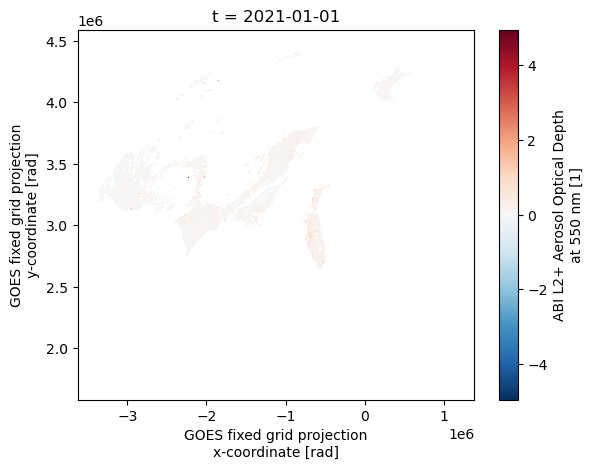

In [9]:
ds.AOD.plot()

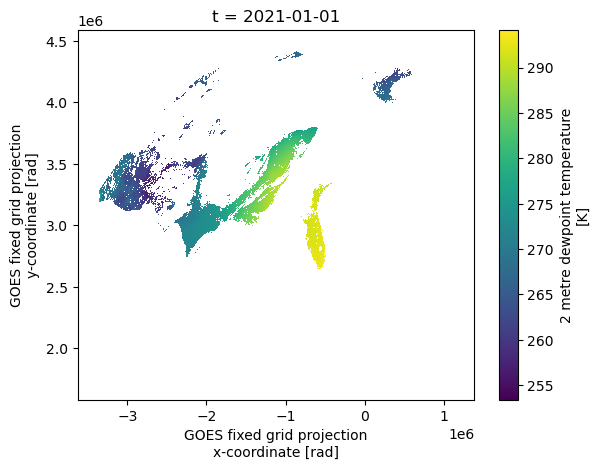

In [10]:
ds.d2m.plot()

Adding back `goes_imager_projection`

In [34]:
with xr.open_dataset('/Volumes/Shores/GOES/AODC/averages/2021/daily/001.nc') as gip:
    gip.load()

In [10]:
drop = ['x_image', 'y_image', 'sunglint_angle', 'retrieval_local_zenith_angle', 'quantitative_local_zenith_angle','retrieval_solar_zenith_angle','quantitative_solar_zenith_angle','aod_product_wavelength']

In [37]:
files = sorted(glob.glob(f'/Volumes/Shores/matched/*.nc'))
pbar = tqdm(files)

for idx, file in enumerate(pbar):
    with xr.open_dataset(file) as ds:
        ds.load()
        
    ds['goes_imager_projection'] = gip['goes_imager_projection']
    
    ds.drop_vars(drop).to_netcdf(file)

  0%|          | 0/365 [00:00<?, ?it/s]

In [55]:
with xr.open_dataset(f'/Volumes/Shores/GOES/AODC/averages/2017/daily/348.nc') as a:
    a.load()
a.goes_imager_projection.perspective_point_height, a.goes_imager_projection.longitude_of_projection_origin, a.t

(35786023.0,
 -75.0,
 <xarray.DataArray 't' (t: 6558)>
 array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
        '2000-01-03T00:00:00.000000000', ..., '2017-12-12T00:00:00.000000000',
        '2017-12-13T00:00:00.000000000', '2017-12-14T00:00:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * t                                (t) datetime64[ns] 2000-01-01 ... 2017-1...
     y_image                          float32 0.08624
     x_image                          float32 -0.03136
     sunglint_angle                   float32 40.0
     retrieval_local_zenith_angle     float32 90.0
     quantitative_local_zenith_angle  float32 60.0
     retrieval_solar_zenith_angle     float32 90.0
     quantitative_solar_zenith_angle  float32 80.0
     aod_product_wavelength           float32 nan)